In [1]:
import sys
from pathlib import Path
ROOT = Path.cwd().parent          
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

In [2]:
from analysis.models import Paper
from analysis.data_io import import_corpus
from analysis.forecast import proj_from_year_series
from analysis.counts import occurrence_freq_by_year, occurrences_by_year
from analysis.plots import plot_word_timeseries
from analysis.lexicon import LLM_WORDS_EN

from pydantic import TypeAdapter
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 
import spacy

In [3]:
papers = import_corpus(batch_size=100, streaming=False, url="julilili42/papers", adapter = TypeAdapter(list[Paper]))
rows = [(a.date.year, a.article) for a in papers]
year, articles = zip(*rows)

58419 articles to be loaded for dataset papers


In [4]:
# distribution of articles for years
year_distribution = pd.Series(year).value_counts().sort_index()
# generate word matrix 
vec = CountVectorizer(
    lowercase=True,
    token_pattern=r"(?u)\b[a-z]{4,}\b",
    binary=True,
    max_features=200000
)
word_matrix_bin = vec.fit_transform(articles)
vocab = vec.get_feature_names_out()

Text(0, 0.5, 'Number of articles')

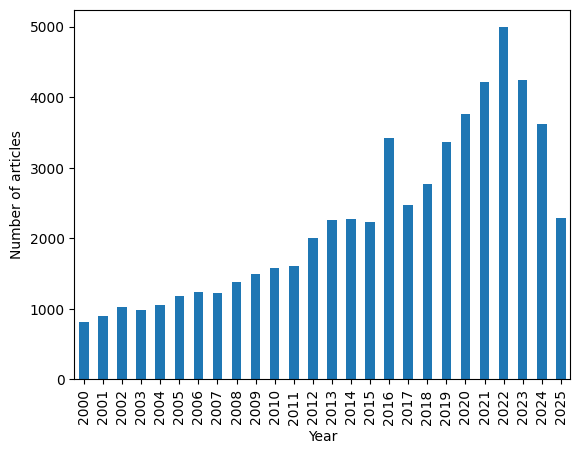

In [5]:
ax = year_distribution.plot(kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("Number of articles")

In [6]:
occurence_freq = occurrence_freq_by_year(year=year, word_matrix_bin=word_matrix_bin, vocab=vocab)
occurence_counts = occurrences_by_year(year=year, word_matrix=word_matrix_bin, vocab=vocab)

Goal: try to find words which disproportionaly increased in use, by interpolating use in year 2024 

- frequency gap $\delta = p - q$ $\implies$ highlights excess usage of frequent words
- frequency ratio $r = \frac{p}{q}$ $\implies$ highlights excess usage of infrequent words.

In [7]:
eps = 1e-9
min_q = 5e-4
min_p = 5e-3

train = occurence_freq.loc[2000:2021]
train_baseline = train.mean()

p = occurence_freq.loc[2024]
q = occurence_freq.loc[:2024].apply(proj_from_year_series, axis=0)

# metrics
delta = p - q
ratio = p / np.maximum(q, eps)
growth = np.log((p + eps) / (train_baseline + eps))

metrics_df = pd.DataFrame({"p": p, "q": q, "delta": delta, "ratio": ratio, "growth": growth})

min_q = 5e-4
min_p = 5e-3
mask_ratio = (metrics_df["q"] > min_q) & (metrics_df["p"] > min_p)
excess = metrics_df.loc[mask_ratio]


In [8]:
# Number of papers in 2024 (to estimate variance)
N2024 = int(pd.Series(year).value_counts().sort_index().loc[2024])

# z = (p - q) / sqrt( q*(1-q)/N )
var = np.maximum(q * (1.0 - q) / max(N2024, 1), eps)
z_gap = (p - q) / np.sqrt(var)

# Log-Ratio
log_ratio = np.log((p + eps) / (q + eps))

# LLM Shift Index
use_gap = (q > min_q) & (p > min_p)
idx_llm_shift = np.where(use_gap, z_gap, log_ratio)
idx_llm_shift = pd.Series(idx_llm_shift, index=p.index, name="llm_shift")

shift_metrics = metrics_df.assign(
    log_ratio=log_ratio,
    z_gap=z_gap,
    llm_shift=idx_llm_shift
).sort_values("llm_shift", ascending=False)

In [9]:
shift_metrics.head(20)

,p,q,delta,ratio,growth,log_ratio,z_gap,llm_shift
underscores,0.012690,0.000801,0.011888,1.583352e+01,2.670286,2.762128,25.293473,25.293473
abstract,0.416828,0.282108,0.134720,1.477547e+00,0.663521,0.390383,18.023878,18.023878
underscore,0.009931,0.001002,0.008929,9.913159e+00,2.180123,2.293862,16.993957,16.993957
enhance,0.038897,0.010819,0.028077,3.595050e+00,1.064028,1.279558,16.340488,16.340488
stretchy,0.003034,0.000000,0.003034,3.034483e+06,2.138392,14.925552,95.958770,14.925552
undersampling,0.002759,0.000000,0.002759,2.758621e+06,3.737661,14.830242,87.235246,14.830242
vibe,0.002759,0.000000,0.002759,2.758621e+06,2.714041,14.830242,87.235246,14.830242
chatgpt,0.002483,0.000000,0.002483,2.482759e+06,14.724881,14.724881,78.511721,14.724881
ruling,0.002483,0.000000,0.002483,2.482759e+06,1.406062,14.724881,78.511721,14.724881
conspicuity,0.002483,0.000000,0.002483,2.482759e+06,2.405748,14.724881,78.511721,14.724881


In [10]:
import spacy
# german    de_core_news_lg
# english   en_core_web_lg
nlp = spacy.load("en_core_web_lg")

words = list(excess.index)
pos_tags = {}
for doc in nlp.pipe(words, batch_size=500):
    token = doc[0]
    pos_tags[token.text] = token.pos_

allowed_pos = {"ADJ", "VERB"}
style_words = [w for w, pos in pos_tags.items() if pos in allowed_pos]

excess_style_words = excess.loc[excess.index.isin(style_words)].sort_values("growth", ascending=False)

In [11]:
excess_style_words

,p,q,delta,ratio,growth
contentheadercolor,0.005793,0.002940,0.002853,1.970113,4.088651
leveraging,0.011310,0.006007,0.005303,1.882752,2.742784
underscores,0.012690,0.000801,0.011888,15.833517,2.670286
paleoclimate,0.006621,0.005693,0.000928,1.162916,2.649047
leverages,0.005241,0.004491,0.000750,1.167081,2.504609
...,...,...,...,...,...
give,0.013517,0.027417,-0.013900,0.493018,-0.802911
describes,0.005517,0.013023,-0.007506,0.423639,-0.816545
seems,0.009655,0.012823,-0.003168,0.752953,-0.886685
hope,0.005241,0.009709,-0.004468,0.539821,-0.935679


In [12]:
found_llm_words = [w for w in LLM_WORDS_EN if w in excess.index]

llm_in_df = excess.loc[excess.index.isin(found_llm_words)]

llm_in_df.sort_values("growth", ascending=False)

,p,q,delta,ratio,growth
underscores,0.012690,0.000801,0.011888,15.833517,2.670286
leverages,0.005241,0.004491,0.000750,1.167081,2.504609
notable,0.009103,0.003825,0.005278,2.379974,1.699254
crucially,0.009103,0.004996,0.004107,1.821979,1.556521
notably,0.028138,0.010619,0.017519,2.649744,1.334156
...,...,...,...,...,...
clearly,0.014345,0.012623,0.001722,1.136429,-0.264589
necessary,0.022621,0.031519,-0.008898,0.717687,-0.492562
slightly,0.008000,0.019921,-0.011921,0.401588,-0.521117
considerably,0.005793,0.013944,-0.008151,0.415446,-0.599726


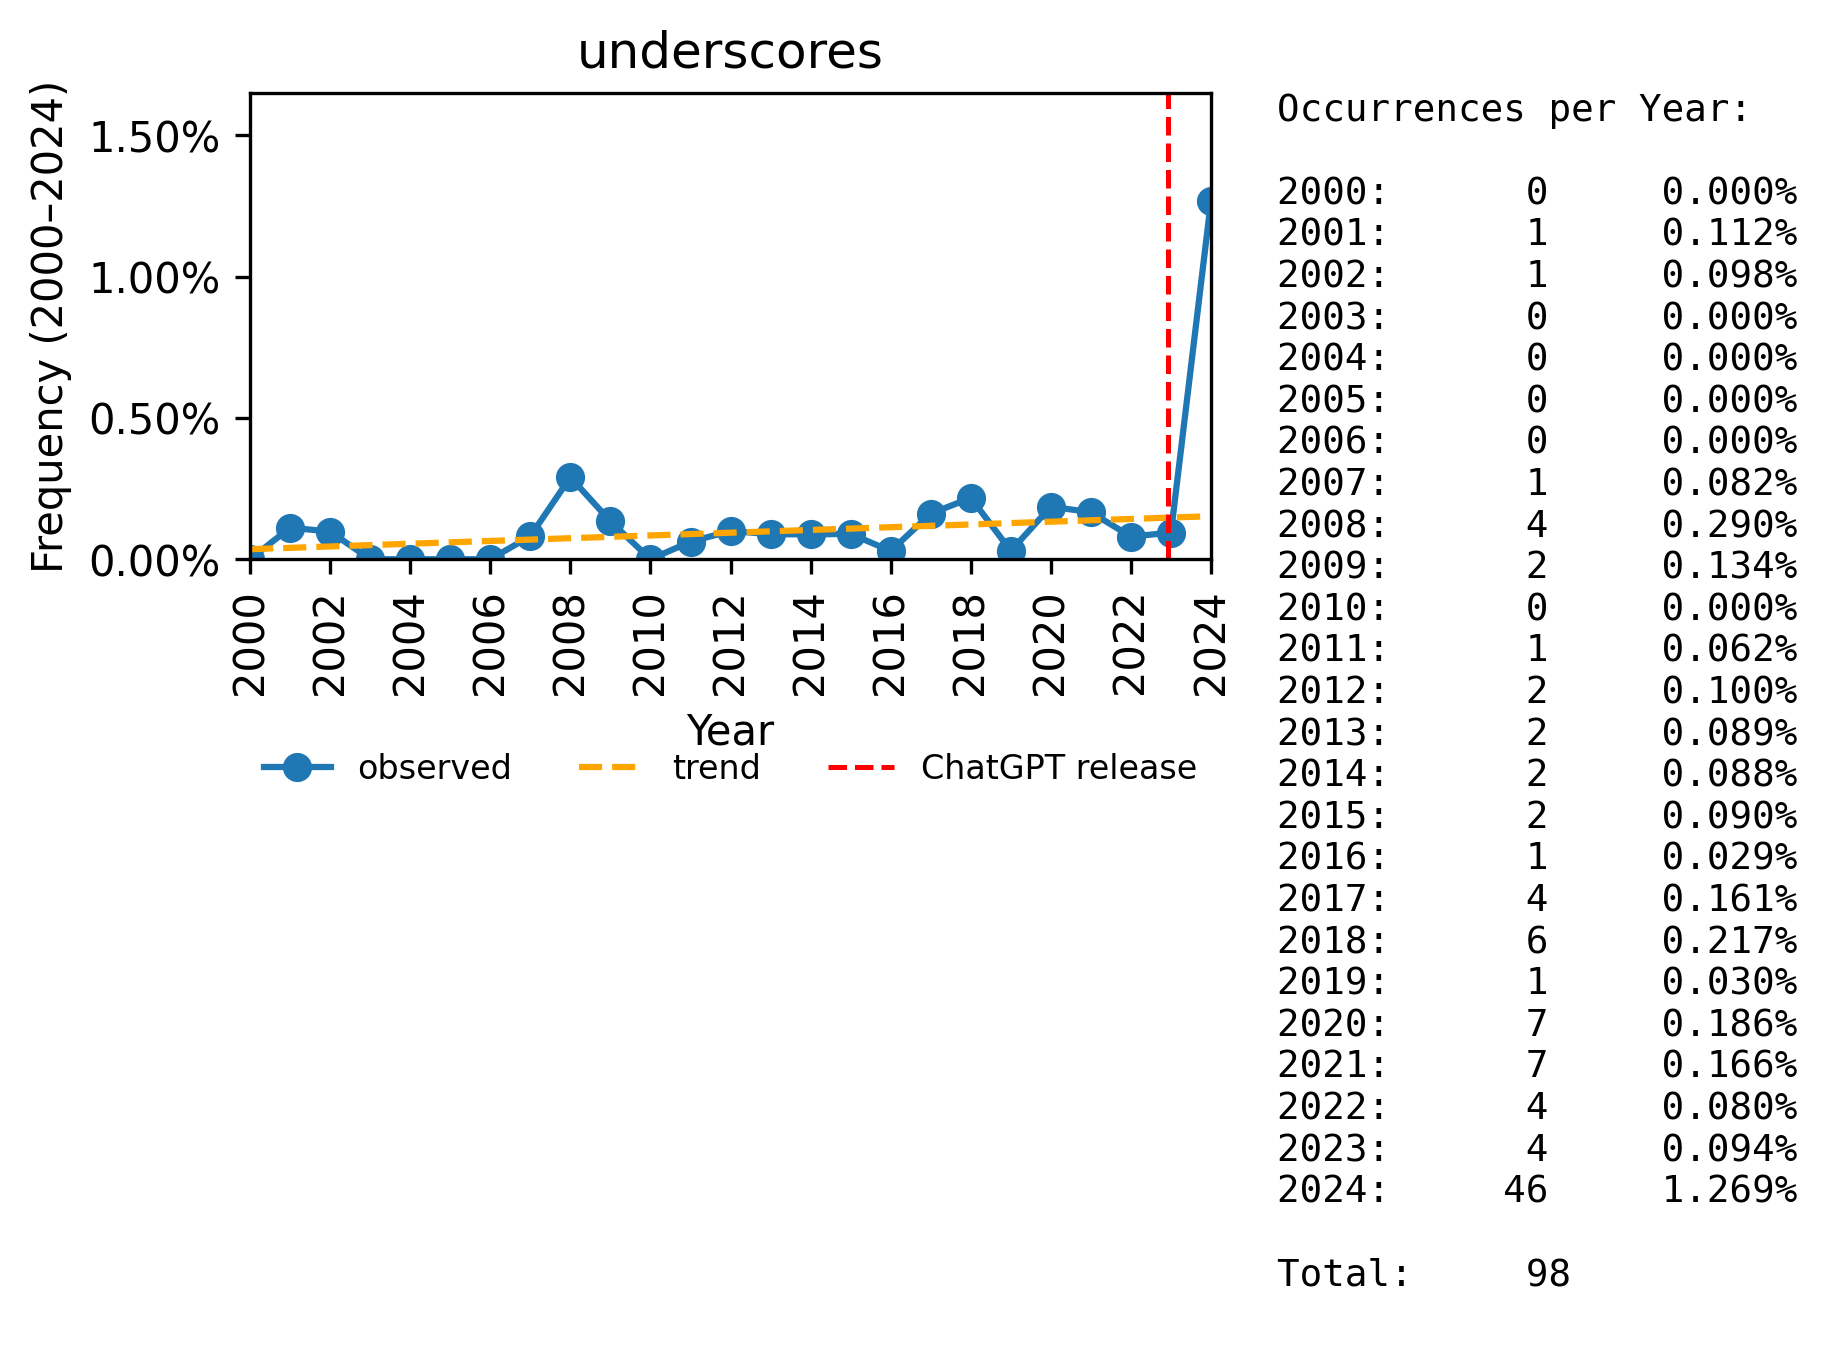

{'p': 0.012689655172413793,
 'q': 0.006709549382130767,
 'delta': 0.005980105790283026}

In [ ]:
plot_word_timeseries(
  word="underscores", 
  occurence_freq=occurence_freq,
  occurrences_abs=occurence_counts,
  year_range=(2000, 2024),
  train_years=(2000, 2020),
  target_year=2024
)